## Install packages

In [ ]:
pip install torch git+https://github.com/pgmpy/pgmpy networkX tqdm

In [ ]:
pip install -U git+https://github.com/zilleanai/zillean_client

In [1]:
import pandas as pd

## Load available modules from the platform

In [2]:
import os
domain = 'backend:5000'
api_root = 'http://'+domain+'/api/v1/'
from zillean_client import load
load(api_root)

zillean_client
importing module: project
importing module: file
importing module: tag
importing module: csv
importing module: pgm


In [3]:
from zillean_client.project import project as projectapi
api = projectapi(project={'api_root': api_root, 'name': 'test'})
print(api.list())

[{'createdAt': '2019-06-06T17:07:20.741493+00:00', 'id': 1, 'name': 'pgm', 'updatedAt': '2019-06-06T17:07:20.741493+00:00'}]


## Load probability graphical model from a project on the platform

In [4]:
from zillean_client.pgm import pgm as pgmapi
pgm_api = pgmapi(project={'api_root': api_root, 'name': 'pgm'})
print(pgm_api.list())

['dd05ddc1-b8dd-4121-b00e-cf31fac5009d']


In [5]:
from pgmpy.models import BayesianModel
pgm = pgm_api.pgmpy(pgm_api.list()[0], BayesianModel)

In [6]:
print('nodes: ', pgm.nodes())
print('edges: ', pgm.edges())

nodes:  ['action', 'price', 'ask_price_0', 'ask_quantity_0', 'bid_price_0', 'bid_quantity_0']
edges:  [('price', 'action'), ('ask_price_0', 'action'), ('ask_quantity_0', 'action'), ('bid_price_0', 'action'), ('bid_quantity_0', 'action')]


In [7]:
pgm.get_independencies()

(price _|_ bid_quantity_0, ask_quantity_0, bid_price_0, ask_price_0)
(price _|_ bid_quantity_0, ask_quantity_0, bid_price_0 | ask_price_0)
(price _|_ bid_quantity_0, bid_price_0, ask_price_0 | ask_quantity_0)
(price _|_ ask_quantity_0, bid_price_0, ask_price_0 | bid_quantity_0)
(price _|_ bid_quantity_0, ask_quantity_0, ask_price_0 | bid_price_0)
(price _|_ bid_quantity_0, bid_price_0 | ask_quantity_0, ask_price_0)
(price _|_ ask_quantity_0, bid_price_0 | bid_quantity_0, ask_price_0)
(price _|_ bid_quantity_0, ask_quantity_0 | bid_price_0, ask_price_0)
(price _|_ bid_price_0, ask_price_0 | bid_quantity_0, ask_quantity_0)
(price _|_ bid_quantity_0, ask_price_0 | ask_quantity_0, bid_price_0)
(price _|_ ask_quantity_0, ask_price_0 | bid_quantity_0, bid_price_0)
(price _|_ bid_price_0 | bid_quantity_0, ask_quantity_0, ask_price_0)
(price _|_ bid_quantity_0 | ask_quantity_0, bid_price_0, ask_price_0)
(price _|_ ask_quantity_0 | bid_quantity_0, bid_price_0, ask_price_0)
(price _|_ ask_price_

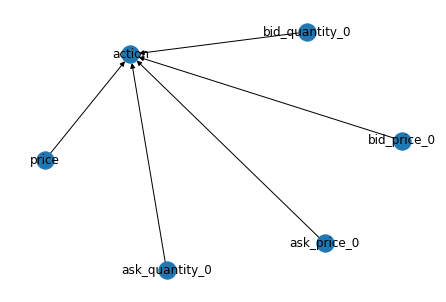

In [10]:
import networkx as nx
import pylab as plt
nx.draw(pgm, with_labels=True)
plt.show()

## Load some data from a project on the platform

In [11]:
from zillean_client.file import file as fileapi
file_api = fileapi(project={'api_root': api_root, 'name': 'pgm'})
print('files:', file_api.files())

files: ['workflow.yml', 'ETH-USDT_2019-01-01T00:00:01_2019-01-01T06:00:01.gz', 'ETH-USDT_2019-02-01T06:00:00_2019-02-01T12:00:00.gz', 'ETH-USDT_2019-03-01T12:00:06_2019-03-01T18:00:06.gz', 'ETH-USDT_2019-04-01T07:30:34_2019-04-01T13:30:34.gz', 'ETH-USDT_2019-05-01T07:02:42_2019-05-01T13:02:42.gz', 'ETH-USDT_2018-12-06T12:00:00_2018-12-06T18:00:00.gz', 'database.db', 'label.py', 'dd05ddc1-b8dd-4121-b00e-cf31fac5009d_pgm.json', 'dd05ddc1-b8dd-4121-b00e-cf31fac5009d_distributions.json', 'model.py']


In [12]:
%%time
from zillean_client.csv import csv as csvapi
csv_api = csvapi(project={'api_root': api_root, 'name': 'pgm'})
print('csvs:', csv_api.list())
df = csv_api.download(csv_api.list()[0])
df

csvs: ['ETH-USDT_2019-01-01T00:00:01_2019-01-01T06:00:01.gz', 'ETH-USDT_2019-02-01T06:00:00_2019-02-01T12:00:00.gz', 'ETH-USDT_2019-03-01T12:00:06_2019-03-01T18:00:06.gz', 'ETH-USDT_2019-04-01T07:30:34_2019-04-01T13:30:34.gz', 'ETH-USDT_2019-05-01T07:02:42_2019-05-01T13:02:42.gz', 'ETH-USDT_2018-12-06T12:00:00_2018-12-06T18:00:00.gz']
CPU times: user 59.5 ms, sys: 6.47 ms, total: 66 ms
Wall time: 158 ms


In [13]:
data = df[list(pgm.nodes())]
data = data.dropna().astype(int)
data[:10]

action  price  ask_price_0  ask_quantity_0  bid_price_0  bid_quantity_0
10       0    131          131              11          131               2
11       0    131          131               2          131               2
12       0    131          131               2          131              52
13       0    131          131               0          131              16
14       0    131          131               7          131               0
15       0    131          131              36          131               0
16       0    131          131              16          131               0
17       0    131          131              61          131               0
18       0    131          131              70          131               4
19       0    131          131               0          131              11

## Train the model on the data

In [14]:
%%time
train_data = data[:1000]
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
pgm.fit(train_data, estimator=MaximumLikelihoodEstimator)

CPU times: user 24.8 s, sys: 210 ms, total: 25 s
Wall time: 24.7 s


## Predict some data

In [16]:
predict_data = data[1000:1015]
predict_data = predict_data.copy()
predict_data.drop('price', axis=1, inplace=True)
y_prob = pgm.predict_probability(predict_data)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [18]:
y_prob[:5]

price_131  price_132
1010      0.941      0.059
1011      0.941      0.059
1012      0.941      0.059
1013      0.941      0.059
1014      0.941      0.059